## Install Essential Packages

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 467 kB 4.9 MB/s 


## Install Essential Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

import numpy as np
import pandas as pd

## Read the Dataset

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


## Part 1 : Dataset Details

In [ ]:
def Information_Extaction(dataset):
  print('There is %d graph in the dataset.' %len(dataset))
  print('The graph has %d nodes.' %dataset[0].num_nodes)
  print('The graph has %d edges.' %dataset[0].num_edges)
  print('Each node has %d features.' %dataset[0].num_features)
  print('These are %d classes.'  %dataset.num_classes)
  print("The Average degree for each node is %d." %round((2*dataset[0].num_edges) / (dataset[0].num_nodes),4))
  print('There are %d training nodes in the dataset.' %dataset[0].train_mask.sum().item())
  return

In [ ]:
Information_Extaction(dataset)

There is 1 graph in the dataset.
The graph has 2708 nodes.
The graph has 10556 edges.
Each node has 1433 features.
These are 7 classes.
The Average degree for each node is 7.
There are 140 training nodes in the dataset.


## Visualization Functions

In [ ]:
def visualize(h, color, title):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.title('Visualization using 2-componenet of TSNE / '+ title)
    plt.show()


def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):

    plt.figure(figsize=(12,6),linewidth = 7, edgecolor="whitesmoke")
    n = n_epochs

    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")

    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')

    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)

    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()


In [ ]:
visualize(dataset[0].x, color=dataset[0].y)

## Additional Libraries for GNN

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import numpy as np

## Part 5 : GCN Implementation

In [ ]:
class GCN_2(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=16,
        ):

        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
class GCN_3(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=16,

        ):

        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, hidden_channel)
        self.conv3 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x


In [ ]:
class GCN_5(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=16,
        ):

        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, hidden_channel)
        self.conv3 = GCNConv(hidden_channel, hidden_channel)
        self.conv4 = GCNConv(hidden_channel, hidden_channel)
        self.conv5 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return x


In [ ]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        data,
        model,
        learning_rate=0.01,
        n_epochs=100,
        min_valid_loss=np.inf,
        ):
      super().__init__()
      self.data = data
      self.model = model
      self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.n_epochs = n_epochs
      self.min_valid_loss = min_valid_loss

    def train_one_epoch(self):
          save_model_flag = False
          self.model.train()
          self.optimizer.zero_grad()

          out = self.model(self.data)
          train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
          validation_loss = self.criterion(out[self.data.val_mask], data.y[self.data.val_mask])

          pred = out.argmax(dim=1)
          train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
          train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
          validation_correct = pred[self.data.val_mask] == data.y[self.data.val_mask]
          validation_acc = int(validation_correct.sum()) / int(self.data.val_mask.sum())

          if self.min_valid_loss > validation_loss:
              save_model_flag = True

          train_loss.backward()
          self.optimizer.step()

          return train_loss, train_acc, validation_loss, validation_acc, save_model_flag

    def train(self, best_model_saving_path):
      list_train_loss, list_train_acc, list_val_loss, list_val_acc = [], [], [], []

      for epoch in range(1, self.n_epochs+1):
        train_loss, train_acc, validation_loss, validation_acc, save_model_flag = self.train_one_epoch()
        list_train_loss.append(float(train_loss.detach()))
        list_train_acc.append(train_acc)
        list_val_loss.append(float(validation_loss.detach()))
        list_val_acc.append(validation_acc)
        print(f'Epoch: {epoch:03d}, Trian Loss: {train_loss:.4f}, Trian Accuracy: {train_acc:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}')

        if save_model_flag:
          self.min_valid_loss = validation_loss
          print(f" ******* Best model updated in epoch: {epoch}, Best validation loss: {self.min_valid_loss:.4f} *******")
          torch.save(self.model, best_model_saving_path)

      return list_train_loss, list_train_acc, list_val_loss, list_val_acc

    def test(self, best_model_path):
        model = torch.load(best_model_path)
        model.eval()
        out = model(self.data)
        test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == self.data.y[self.data.test_mask]
        test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
        return test_acc, test_loss


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

##2-Layer-GCN (hidden_channel=16)

In [ ]:
gcn2_model = GCN_2(hidden_channel = 16)
print(gcn2_model)

GCN_2(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Model Training

In [ ]:
evaluate_GCN2 = Leaning_Evaluation(data=data,
                                   model = gcn2_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN2.train(best_model_saving_path='GCN2_16_best_model.pth')


Epoch: 001, Trian Loss: 1.9457, Trian Accuracy: 0.1286, Validation Loss: 1.9467, Validation Accuracy: 0.1020
 ******* Best model updated in epoch: 1, Best validation loss: 1.9467 *******
Epoch: 002, Trian Loss: 1.9392, Trian Accuracy: 0.2357, Validation Loss: 1.9422, Validation Accuracy: 0.1900
 ******* Best model updated in epoch: 2, Best validation loss: 1.9422 *******
Epoch: 003, Trian Loss: 1.9317, Trian Accuracy: 0.4143, Validation Loss: 1.9390, Validation Accuracy: 0.2540
 ******* Best model updated in epoch: 3, Best validation loss: 1.9390 *******
Epoch: 004, Trian Loss: 1.9224, Trian Accuracy: 0.3929, Validation Loss: 1.9373, Validation Accuracy: 0.2640
 ******* Best model updated in epoch: 4, Best validation loss: 1.9373 *******
Epoch: 005, Trian Loss: 1.9107, Trian Accuracy: 0.5429, Validation Loss: 1.9317, Validation Accuracy: 0.3660
 ******* Best model updated in epoch: 5, Best validation loss: 1.9317 *******
Epoch: 006, Trian Loss: 1.9033, Trian Accuracy: 0.5786, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN2.test(best_model_path='GCN2_16_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7780, Test loss: 0.7187


### Visualization

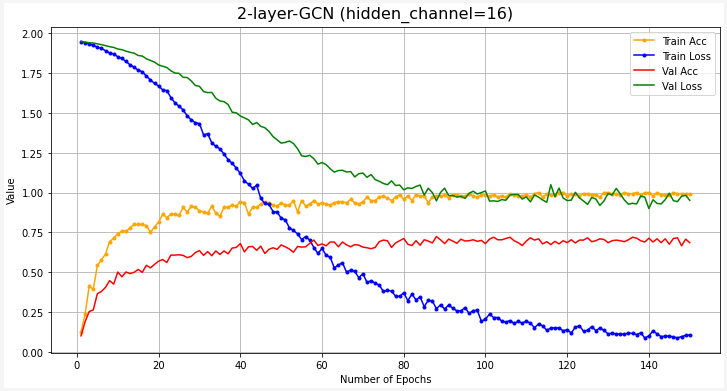

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN2.n_epochs, title='2-layer-GCN (hidden_channel=16)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


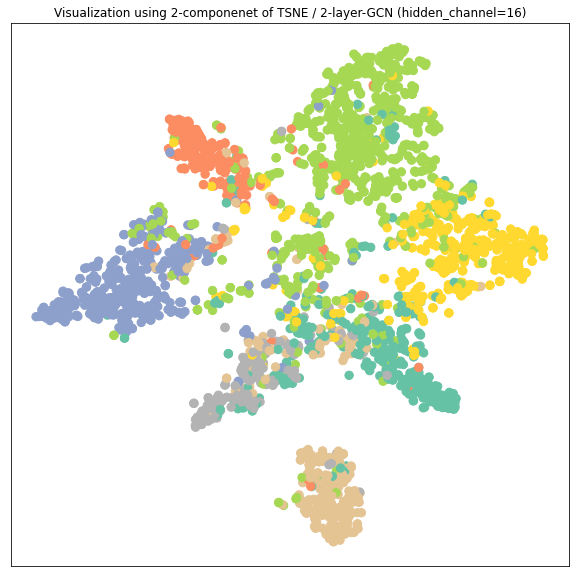

In [ ]:
model = torch.load('GCN2_16_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='2-layer-GCN (hidden_channel=16)')

##3-Layer-GCN (hidden_channel=16)

In [ ]:
gcn3_model = GCN_3(hidden_channel = 16)
print(gcn3_model)

GCN_3(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 7)
)


### Model Training

In [ ]:
evaluate_GCN3 = Leaning_Evaluation(data,
                                   gcn3_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN3.train(best_model_saving_path='GCN3_16_best_model.pth')


Epoch: 001, Trian Loss: 1.9461, Trian Accuracy: 0.1286, Validation Loss: 1.9455, Validation Accuracy: 0.1600
 ******* Best model updated in epoch: 1, Best validation loss: 1.9455 *******
Epoch: 002, Trian Loss: 1.9414, Trian Accuracy: 0.1643, Validation Loss: 1.9429, Validation Accuracy: 0.1520
 ******* Best model updated in epoch: 2, Best validation loss: 1.9429 *******
Epoch: 003, Trian Loss: 1.9319, Trian Accuracy: 0.3214, Validation Loss: 1.9370, Validation Accuracy: 0.2940
 ******* Best model updated in epoch: 3, Best validation loss: 1.9370 *******
Epoch: 004, Trian Loss: 1.9241, Trian Accuracy: 0.3000, Validation Loss: 1.9319, Validation Accuracy: 0.2600
 ******* Best model updated in epoch: 4, Best validation loss: 1.9319 *******
Epoch: 005, Trian Loss: 1.9171, Trian Accuracy: 0.4000, Validation Loss: 1.9236, Validation Accuracy: 0.2860
 ******* Best model updated in epoch: 5, Best validation loss: 1.9236 *******
Epoch: 006, Trian Loss: 1.9083, Trian Accuracy: 0.3429, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN3.test(best_model_path='GCN3_16_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7410, Test loss: 0.8586


### Visualization

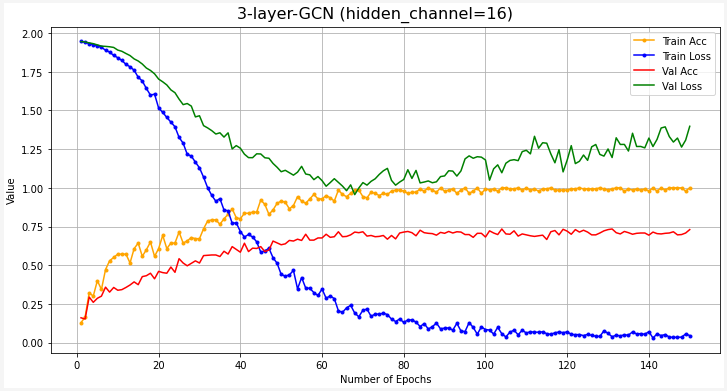

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN3.n_epochs, title='3-layer-GCN (hidden_channel=16)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


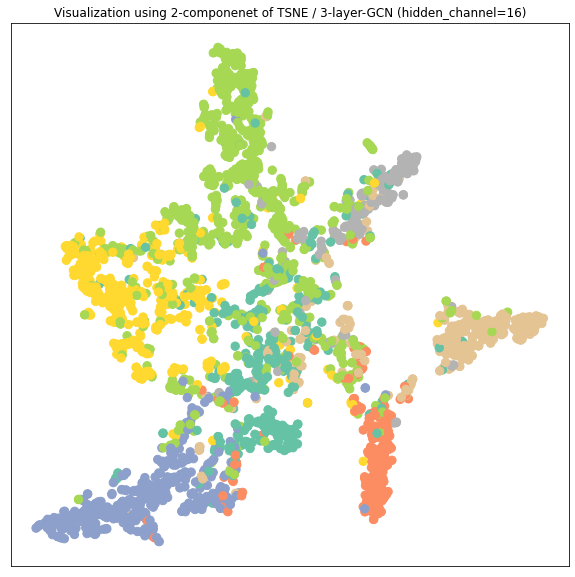

In [ ]:
model = torch.load('GCN3_16_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='3-layer-GCN (hidden_channel=16)')

##5-Layer-GCN (hidden_channel=16)

In [ ]:
gcn5_model = GCN_5(hidden_channel = 16)
print(gcn5_model)

GCN_5(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 7)
)


### Model Training

In [ ]:
evaluate_GCN5 = Leaning_Evaluation(data,
                                   gcn5_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN5.train(best_model_saving_path='GCN5_16_best_model.pth')

Epoch: 001, Trian Loss: 2.7717, Trian Accuracy: 0.1214, Validation Loss: 2.7728, Validation Accuracy: 0.0440
 ******* Best model updated in epoch: 1, Best validation loss: 2.7728 *******
Epoch: 002, Trian Loss: 2.7380, Trian Accuracy: 0.1143, Validation Loss: 2.7386, Validation Accuracy: 0.0700
 ******* Best model updated in epoch: 2, Best validation loss: 2.7386 *******
Epoch: 003, Trian Loss: 2.6803, Trian Accuracy: 0.1429, Validation Loss: 2.6877, Validation Accuracy: 0.1100
 ******* Best model updated in epoch: 3, Best validation loss: 2.6877 *******
Epoch: 004, Trian Loss: 2.6209, Trian Accuracy: 0.1929, Validation Loss: 2.6288, Validation Accuracy: 0.1560
 ******* Best model updated in epoch: 4, Best validation loss: 2.6288 *******
Epoch: 005, Trian Loss: 2.5435, Trian Accuracy: 0.1786, Validation Loss: 2.5654, Validation Accuracy: 0.1540
 ******* Best model updated in epoch: 5, Best validation loss: 2.5654 *******
Epoch: 006, Trian Loss: 2.5000, Trian Accuracy: 0.1429, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN5.test(best_model_path='GCN5_16_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.6580, Test loss: 1.0463


### Visualization

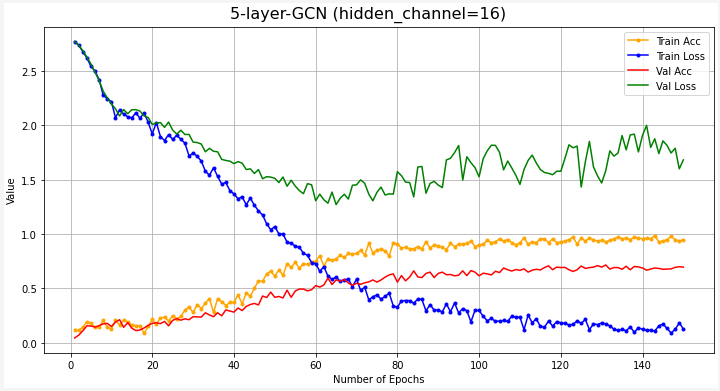

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN5.n_epochs, title='5-layer-GCN (hidden_channel=16)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


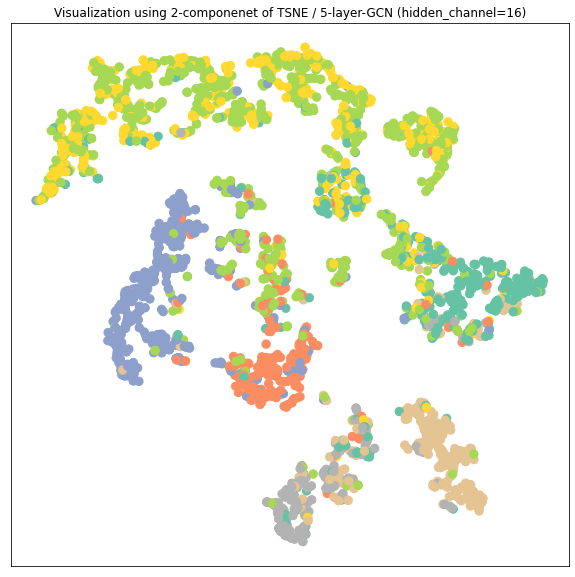

In [ ]:
model = torch.load('GCN5_16_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='5-layer-GCN (hidden_channel=16)')

# Analayze the impact of number of hidden channels

##2-Layer-GCN (hidden_channel=32)

In [ ]:
gcn2_model = GCN_2(hidden_channel = 32)
print(gcn2_model)

GCN_2(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)


### Model Training

In [ ]:
evaluate_GCN2 = Leaning_Evaluation(data=data,
                                   model = gcn2_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN2.train(best_model_saving_path='GCN2_32_best_model.pth')


Epoch: 001, Trian Loss: 1.9461, Trian Accuracy: 0.1500, Validation Loss: 1.9461, Validation Accuracy: 0.1520
 ******* Best model updated in epoch: 1, Best validation loss: 1.9461 *******
Epoch: 002, Trian Loss: 1.9351, Trian Accuracy: 0.5071, Validation Loss: 1.9401, Validation Accuracy: 0.3240
 ******* Best model updated in epoch: 2, Best validation loss: 1.9401 *******
Epoch: 003, Trian Loss: 1.9242, Trian Accuracy: 0.5429, Validation Loss: 1.9376, Validation Accuracy: 0.2940
 ******* Best model updated in epoch: 3, Best validation loss: 1.9376 *******
Epoch: 004, Trian Loss: 1.9105, Trian Accuracy: 0.6500, Validation Loss: 1.9301, Validation Accuracy: 0.3900
 ******* Best model updated in epoch: 4, Best validation loss: 1.9301 *******
Epoch: 005, Trian Loss: 1.8942, Trian Accuracy: 0.7214, Validation Loss: 1.9238, Validation Accuracy: 0.4220
 ******* Best model updated in epoch: 5, Best validation loss: 1.9238 *******
Epoch: 006, Trian Loss: 1.8766, Trian Accuracy: 0.7500, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN2.test(best_model_path='GCN2_32_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.8120, Test loss: 0.6577


### Visualization

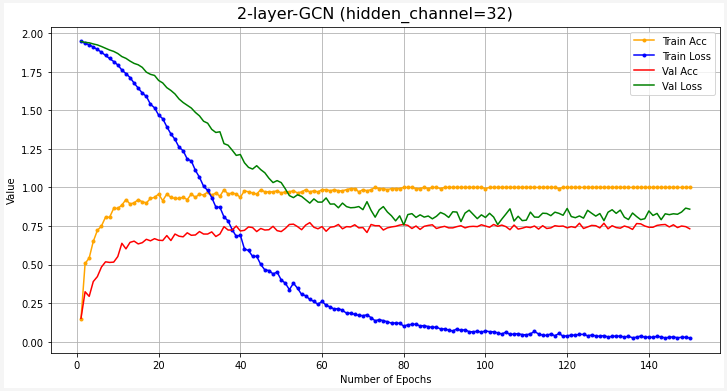

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN2.n_epochs, title='2-layer-GCN (hidden_channel=32)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


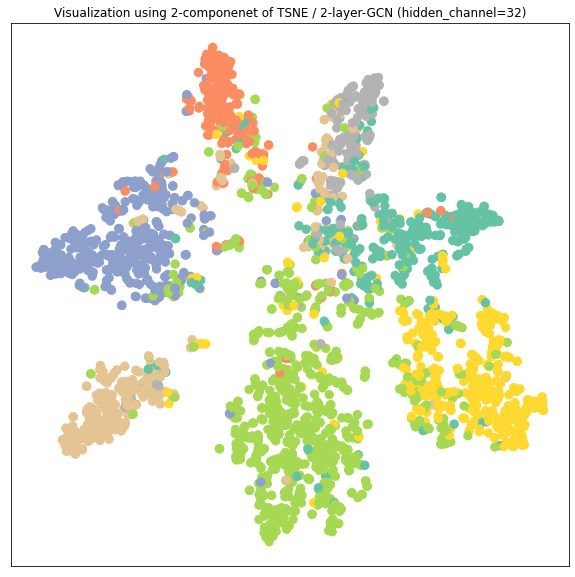

In [ ]:
model = torch.load('GCN2_32_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='2-layer-GCN (hidden_channel=32)')

##3-Layer-GCN (hidden_channel=32)

In [ ]:
gcn3_model = GCN_3(hidden_channel = 32)
print(gcn3_model)

GCN_3(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 7)
)


### Model Training

In [ ]:
evaluate_GCN3 = Leaning_Evaluation(data,
                                   gcn3_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN3.train(best_model_saving_path='GCN3_32_best_model.pth')


Epoch: 001, Trian Loss: 1.9463, Trian Accuracy: 0.1429, Validation Loss: 1.9463, Validation Accuracy: 0.0900
 ******* Best model updated in epoch: 1, Best validation loss: 1.9463 *******
Epoch: 002, Trian Loss: 1.9386, Trian Accuracy: 0.1714, Validation Loss: 1.9461, Validation Accuracy: 0.1340
 ******* Best model updated in epoch: 2, Best validation loss: 1.9461 *******
Epoch: 003, Trian Loss: 1.9241, Trian Accuracy: 0.2786, Validation Loss: 1.9385, Validation Accuracy: 0.1720
 ******* Best model updated in epoch: 3, Best validation loss: 1.9385 *******
Epoch: 004, Trian Loss: 1.9135, Trian Accuracy: 0.3286, Validation Loss: 1.9339, Validation Accuracy: 0.1740
 ******* Best model updated in epoch: 4, Best validation loss: 1.9339 *******
Epoch: 005, Trian Loss: 1.8954, Trian Accuracy: 0.3571, Validation Loss: 1.9245, Validation Accuracy: 0.2080
 ******* Best model updated in epoch: 5, Best validation loss: 1.9245 *******
Epoch: 006, Trian Loss: 1.8773, Trian Accuracy: 0.4643, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN3.test(best_model_path='GCN3_32_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.8050, Test loss: 0.6335


### Visualization

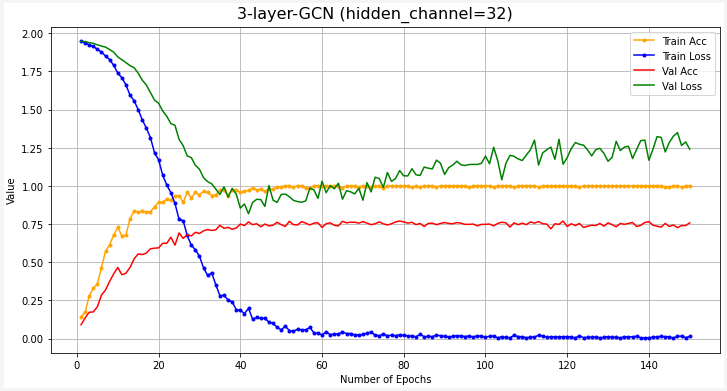

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN3.n_epochs, title='3-layer-GCN (hidden_channel=32)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


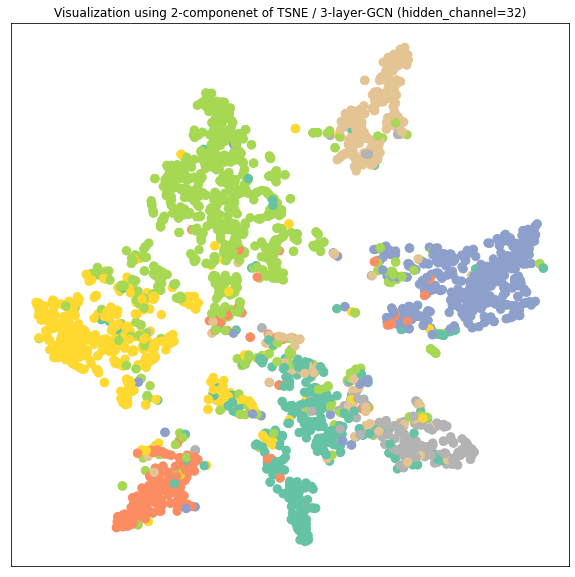

In [ ]:
model = torch.load('GCN3_32_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='3-layer-GCN (hidden_channel=32)')

##5-Layer-GCN (hidden_channel=32)

In [ ]:
gcn5_model = GCN_5(hidden_channel = 32)
print(gcn5_model)

GCN_5(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 32)
  (conv5): GCNConv(32, 7)
)


### Model Training

In [ ]:
evaluate_GCN5 = Leaning_Evaluation(data,
                                   gcn5_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN5.train(best_model_saving_path='GCN5_32_best_model.pth')

Epoch: 001, Trian Loss: 3.4659, Trian Accuracy: 0.0000, Validation Loss: 3.4660, Validation Accuracy: 0.0120
 ******* Best model updated in epoch: 1, Best validation loss: 3.4660 *******
Epoch: 002, Trian Loss: 3.4183, Trian Accuracy: 0.1071, Validation Loss: 3.4144, Validation Accuracy: 0.1200
 ******* Best model updated in epoch: 2, Best validation loss: 3.4144 *******
Epoch: 003, Trian Loss: 3.3330, Trian Accuracy: 0.1714, Validation Loss: 3.3182, Validation Accuracy: 0.1380
 ******* Best model updated in epoch: 3, Best validation loss: 3.3182 *******
Epoch: 004, Trian Loss: 3.2183, Trian Accuracy: 0.1500, Validation Loss: 3.2058, Validation Accuracy: 0.1340
 ******* Best model updated in epoch: 4, Best validation loss: 3.2058 *******
Epoch: 005, Trian Loss: 3.0440, Trian Accuracy: 0.1571, Validation Loss: 2.9884, Validation Accuracy: 0.1400
 ******* Best model updated in epoch: 5, Best validation loss: 2.9884 *******
Epoch: 006, Trian Loss: 2.8329, Trian Accuracy: 0.1286, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN5.test(best_model_path='GCN5_32_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7320, Test loss: 1.0314


### Visualization

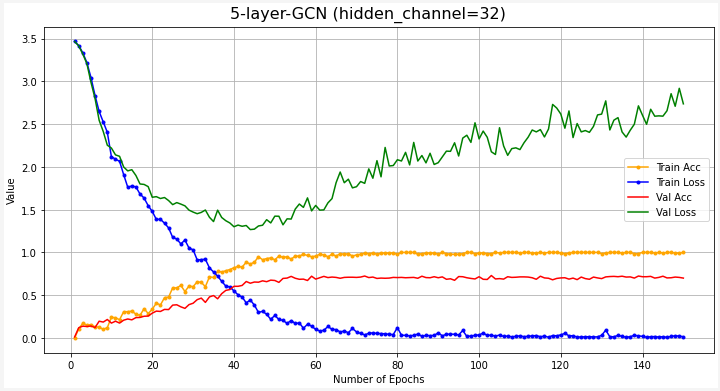

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN5.n_epochs, title='5-layer-GCN (hidden_channel=32)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


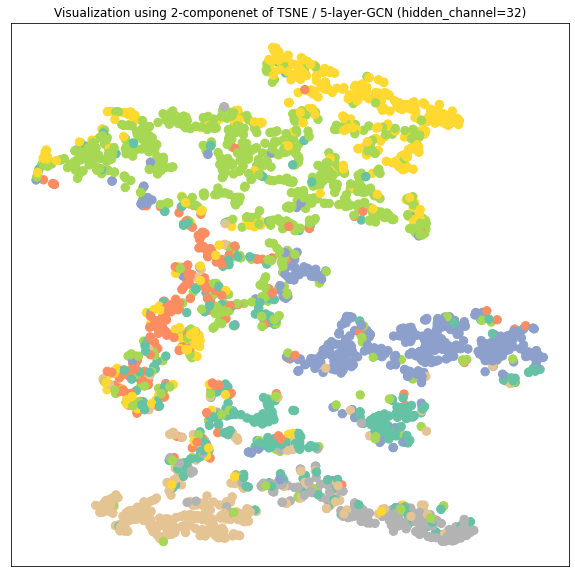

In [ ]:
model = torch.load('GCN5_32_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='5-layer-GCN (hidden_channel=32)')

##2-Layer-GCN (hidden_channel=8)

In [ ]:
gcn2_model = GCN_2(hidden_channel = 8)
print(gcn2_model)

GCN_2(
  (conv1): GCNConv(1433, 8)
  (conv2): GCNConv(8, 7)
)


### Model Training

In [ ]:
evaluate_GCN2 = Leaning_Evaluation(data=data,
                                   model = gcn2_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN2.train(best_model_saving_path='GCN2_8_best_model.pth')


Epoch: 001, Trian Loss: 1.9457, Trian Accuracy: 0.2071, Validation Loss: 1.9467, Validation Accuracy: 0.1180
 ******* Best model updated in epoch: 1, Best validation loss: 1.9467 *******
Epoch: 002, Trian Loss: 1.9403, Trian Accuracy: 0.2571, Validation Loss: 1.9439, Validation Accuracy: 0.1700
 ******* Best model updated in epoch: 2, Best validation loss: 1.9439 *******
Epoch: 003, Trian Loss: 1.9334, Trian Accuracy: 0.4357, Validation Loss: 1.9390, Validation Accuracy: 0.2940
 ******* Best model updated in epoch: 3, Best validation loss: 1.9390 *******
Epoch: 004, Trian Loss: 1.9233, Trian Accuracy: 0.5286, Validation Loss: 1.9356, Validation Accuracy: 0.3500
 ******* Best model updated in epoch: 4, Best validation loss: 1.9356 *******
Epoch: 005, Trian Loss: 1.9162, Trian Accuracy: 0.5571, Validation Loss: 1.9304, Validation Accuracy: 0.4060
 ******* Best model updated in epoch: 5, Best validation loss: 1.9304 *******
Epoch: 006, Trian Loss: 1.9073, Trian Accuracy: 0.5929, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN2.test(best_model_path='GCN2_8_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7680, Test loss: 0.8817


### Visualization

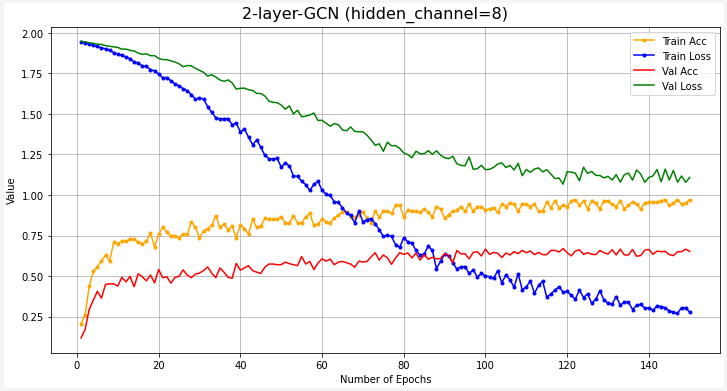

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN2.n_epochs, title='2-layer-GCN (hidden_channel=8)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


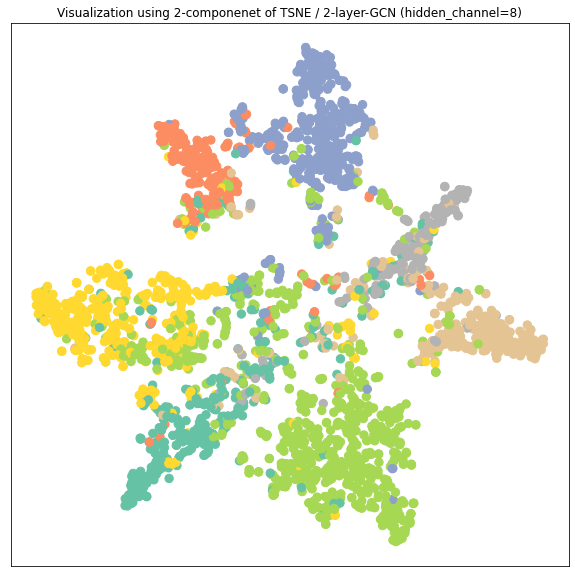

In [ ]:
model = torch.load('GCN2_8_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='2-layer-GCN (hidden_channel=8)')

##3-Layer-GCN (hidden_channel=8)

In [ ]:
gcn3_model = GCN_3(hidden_channel = 8)
print(gcn3_model)

GCN_3(
  (conv1): GCNConv(1433, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 7)
)


### Model Training

In [ ]:
evaluate_GCN3 = Leaning_Evaluation(data,
                                   gcn3_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN3.train(best_model_saving_path='GCN3_8_best_model.pth')


Epoch: 001, Trian Loss: 1.9458, Trian Accuracy: 0.1286, Validation Loss: 1.9453, Validation Accuracy: 0.1640
 ******* Best model updated in epoch: 1, Best validation loss: 1.9453 *******
Epoch: 002, Trian Loss: 1.9436, Trian Accuracy: 0.1429, Validation Loss: 1.9498, Validation Accuracy: 0.0580
Epoch: 003, Trian Loss: 1.9383, Trian Accuracy: 0.2500, Validation Loss: 1.9449, Validation Accuracy: 0.1440
 ******* Best model updated in epoch: 3, Best validation loss: 1.9449 *******
Epoch: 004, Trian Loss: 1.9302, Trian Accuracy: 0.2571, Validation Loss: 1.9354, Validation Accuracy: 0.2320
 ******* Best model updated in epoch: 4, Best validation loss: 1.9354 *******
Epoch: 005, Trian Loss: 1.9228, Trian Accuracy: 0.3000, Validation Loss: 1.9320, Validation Accuracy: 0.2340
 ******* Best model updated in epoch: 5, Best validation loss: 1.9320 *******
Epoch: 006, Trian Loss: 1.9205, Trian Accuracy: 0.2929, Validation Loss: 1.9246, Validation Accuracy: 0.2540
 ******* Best model updated in epo

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN3.test(best_model_path='GCN3_8_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7490, Test loss: 0.8752


### Visualization

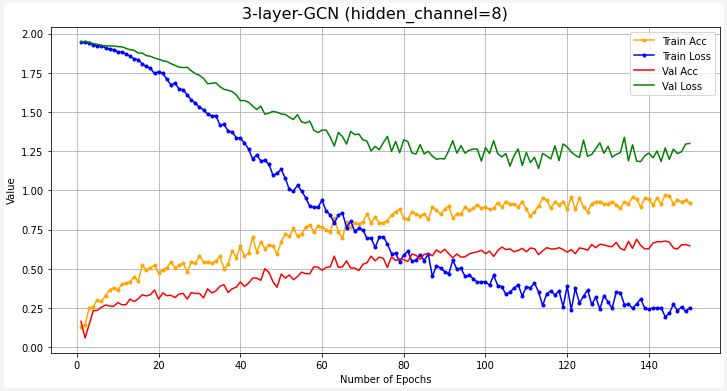

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN3.n_epochs, title='3-layer-GCN (hidden_channel=8)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


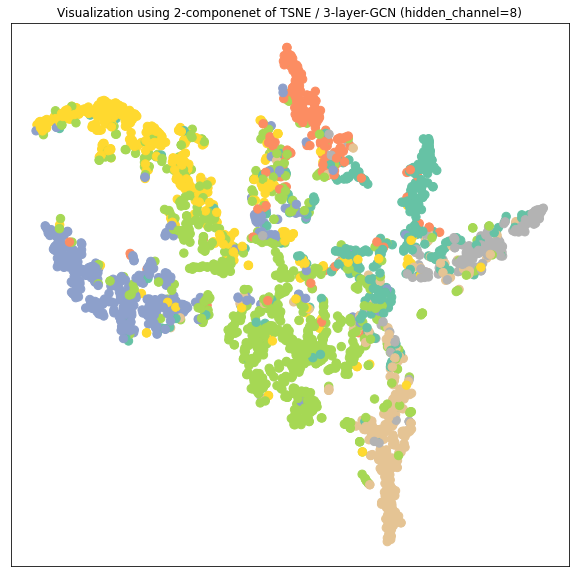

In [ ]:
model = torch.load('GCN3_8_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='3-layer-GCN (hidden_channel=8)')

##5-Layer-GCN (hidden_channel=8)

In [ ]:
gcn5_model = GCN_5(hidden_channel = 8)
print(gcn5_model)

GCN_5(
  (conv1): GCNConv(1433, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 8)
  (conv4): GCNConv(8, 8)
  (conv5): GCNConv(8, 7)
)


### Model Training

In [ ]:
evaluate_GCN5 = Leaning_Evaluation(data,
                                   gcn5_model,
                                   learning_rate=0.01,
                                   n_epochs=150,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN5.train(best_model_saving_path='GCN5_8_best_model.pth')

Epoch: 001, Trian Loss: 2.0794, Trian Accuracy: 0.1429, Validation Loss: 2.0790, Validation Accuracy: 0.2000
 ******* Best model updated in epoch: 1, Best validation loss: 2.0790 *******
Epoch: 002, Trian Loss: 2.0735, Trian Accuracy: 0.1571, Validation Loss: 2.0682, Validation Accuracy: 0.2760
 ******* Best model updated in epoch: 2, Best validation loss: 2.0682 *******
Epoch: 003, Trian Loss: 2.0693, Trian Accuracy: 0.1571, Validation Loss: 2.0619, Validation Accuracy: 0.2540
 ******* Best model updated in epoch: 3, Best validation loss: 2.0619 *******
Epoch: 004, Trian Loss: 2.0593, Trian Accuracy: 0.1429, Validation Loss: 2.0431, Validation Accuracy: 0.2820
 ******* Best model updated in epoch: 4, Best validation loss: 2.0431 *******
Epoch: 005, Trian Loss: 2.0464, Trian Accuracy: 0.1357, Validation Loss: 2.0372, Validation Accuracy: 0.2940
 ******* Best model updated in epoch: 5, Best validation loss: 2.0372 *******
Epoch: 006, Trian Loss: 2.0292, Trian Accuracy: 0.1571, Validatio

### Model Evaluation

In [ ]:
test_acc, test_loss = evaluate_GCN5.test(best_model_path='GCN5_8_best_model.pth')
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.6640, Test loss: 1.0579


### Visualization

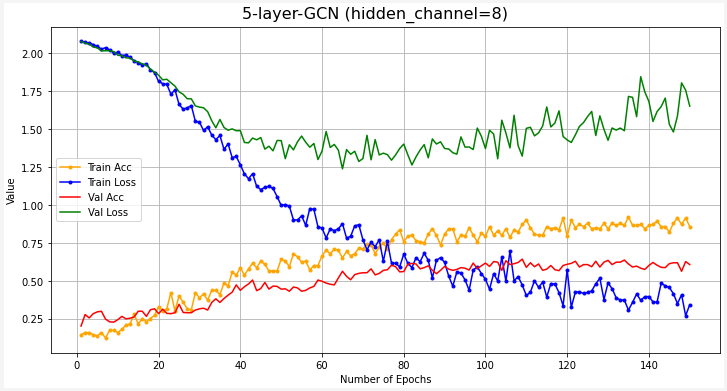

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN5.n_epochs, title='5-layer-GCN (hidden_channel=8)')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


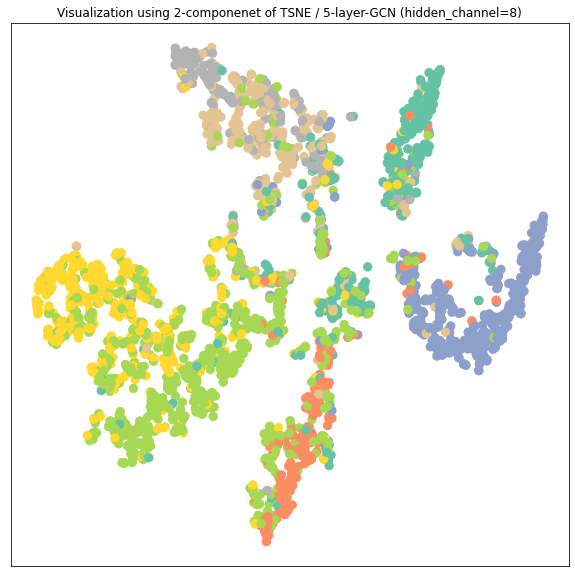

In [ ]:
model = torch.load('GCN5_8_best_model.pth')
model.eval()
out = model(data)
visualize(out, color=data.y, title='5-layer-GCN (hidden_channel=8)')

## Conclusion

In [ ]:
import pandas as pd

In [ ]:
conclusion = pd.DataFrame([['2-layer-GCN (hidden_channel=16)',1.00, 0.1, 0.71, 0.89, 0.77, 0.71, 140],
              ['3-layer-GCN (hidden_channel=16)',0.98, 0.19, 0.71, 0.95, 0.74, 0.85, 68],
              ['5-layer-GCN (hidden_channel=16)',0.77, 0.60, 0.57, 1.27, 0.65, 1.04, 65],
              ['2-layer-GCN (hidden_channel=32)',1.00, 0.1, 0.76, 0.75, 0.81, 0.65, 80],
              ['3-layer-GCN (hidden_channel=32)',0.97, 0.19, 0.76, 0.81, 0.80, 0.63, 42],
              ['5-layer-GCN (hidden_channel=32)',0.86, 0.44, 0.67, 1.26, 0.73, 1.03, 44],
              ['2-layer-GCN (hidden_channel=8)',0.93, 0.4, 0.67, 1.06, 0.76, 0.88, 119],
              ['3-layer-GCN (hidden_channel=8)',0.90, 0.35, 0.59, 1.13, 0.74, 0.87, 113],
              ['5-layer-GCN (hidden_channel=8)',0.65, 0.87, 0.56, 1.23, 0.66, 1.05, 65]],
              columns=["Model Details","Train Accuracy","Train loss","validation Accuracy","Validation loss","Test Accuracy","Test loss",'Epoch with best result'])
conclusion = conclusion.set_index('Model Details')
conclusion.style.background_gradient(cmap="YlOrRd")


,Train Accuracy,Train loss,validation Accuracy,Validation loss,Test Accuracy,Test loss,Epoch with best result
Model Details,,,,,,,
2-layer-GCN (hidden_channel=16),1.000000,0.100000,0.710000,0.890000,0.770000,0.710000,140
3-layer-GCN (hidden_channel=16),0.980000,0.190000,0.710000,0.950000,0.740000,0.850000,68
5-layer-GCN (hidden_channel=16),0.770000,0.600000,0.570000,1.270000,0.650000,1.040000,65
2-layer-GCN (hidden_channel=32),1.000000,0.100000,0.760000,0.750000,0.810000,0.650000,80
3-layer-GCN (hidden_channel=32),0.970000,0.190000,0.760000,0.810000,0.800000,0.630000,42
5-layer-GCN (hidden_channel=32),0.860000,0.440000,0.670000,1.260000,0.730000,1.030000,44
2-layer-GCN (hidden_channel=8),0.930000,0.400000,0.670000,1.060000,0.760000,0.880000,119
3-layer-GCN (hidden_channel=8),0.900000,0.350000,0.590000,1.130000,0.740000,0.870000,113
5-layer-GCN (hidden_channel=8),0.650000,0.870000,0.560000,1.230000,0.660000,1.050000,65
